In [3]:
import os
import csv
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_filter
from skimage import img_as_float
from skimage.feature import canny
from skimage import morphology
from skimage.morphology import reconstruction
from skimage.measure import label
from matplotlib.pyplot import imshow
from skimage import io, color, morphology, measure
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm

In [18]:
read_dir = "daylight_preprocessed_images"

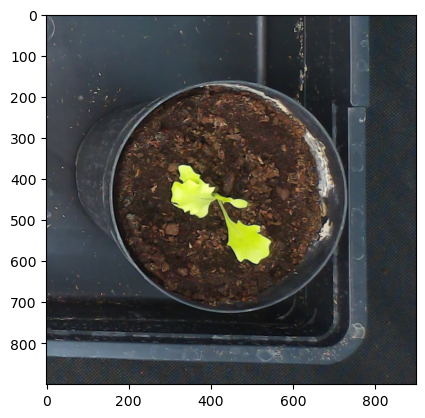

In [19]:
img = imread(f"{read_dir}/lettuce4_2024-07-02_15.jpg")
image = img_as_float(img)
imshow(image)

### Another Attemps

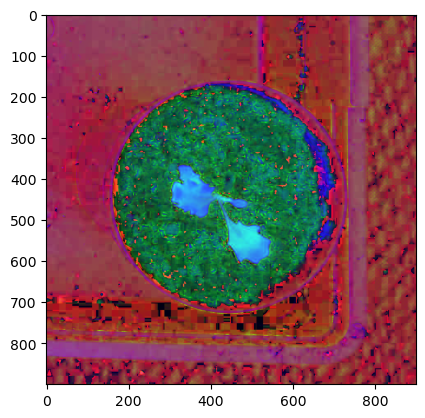

In [10]:
hsv_image = color.rgb2hsv(image)
imshow(hsv_image);

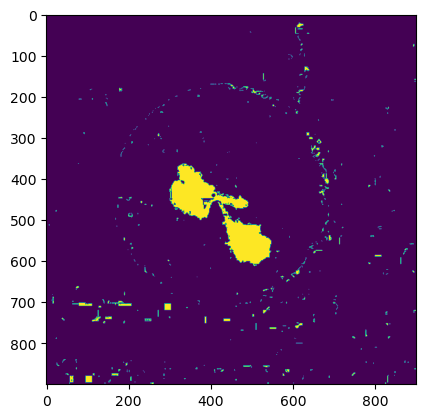

In [11]:
lower_hue = 0.15 # Adjust as needed
upper_hue = 0.2 # Adjust as needed
green_mask = (hsv_image[:, :, 0] >= lower_hue) & (hsv_image[:, :, 0] <= upper_hue)

imshow(green_mask);

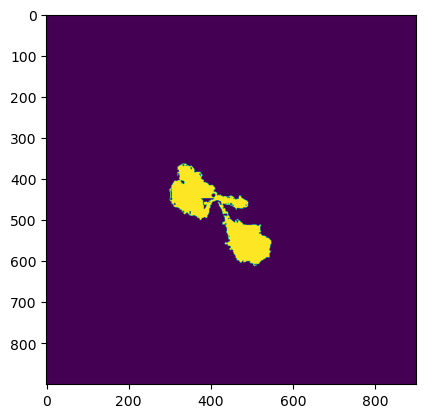

In [13]:
cleaned_mask = morphology.remove_small_objects(green_mask, min_size=500)
imshow(cleaned_mask);

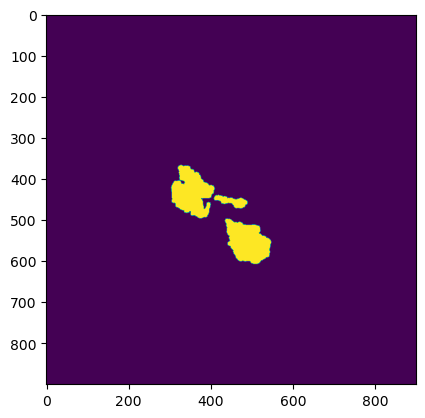

In [14]:
selem = morphology.disk(5)
opened_mask = morphology.opening(cleaned_mask, selem)
imshow(opened_mask);

In [15]:
labeled_leaves = measure.label(opened_mask)
leaf_count = np.max(labeled_leaves)
print("Number of leaves %d " % leaf_count)

Number of leaves 3 


### Wrapping into function

In [16]:
def count_leaves(img, verbose=False):
    image = img_as_float(img)
    if verbose:
        imshow(image)
        plt.show()
    hsv_image = color.rgb2hsv(image)
    if verbose:
        imshow(hsv_image)
        plt.show()
    lower_hue = 0.15 # Adjust as needed
    upper_hue = 0.2 # Adjust as needed
    green_mask = (hsv_image[:, :, 0] >= lower_hue) & (hsv_image[:, :, 0] <= upper_hue)
    if verbose:
        imshow(green_mask)
        plt.show()
    cleaned_mask = morphology.remove_small_objects(green_mask, min_size=500)
    if verbose:
        imshow(cleaned_mask)
        plt.show()
    selem = morphology.disk(5)
    opened_mask = morphology.opening(cleaned_mask, selem)
    if verbose:
        imshow(opened_mask)
        plt.show()
    labeled_leaves = measure.label(opened_mask)
    leaf_count = np.max(labeled_leaves)
    return leaf_count

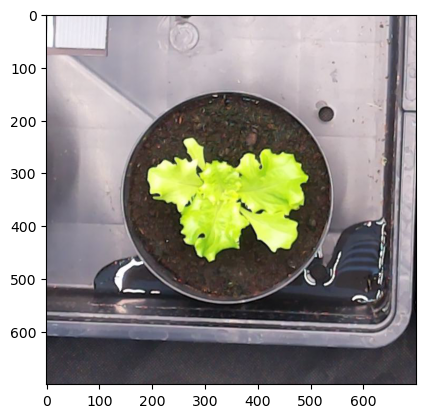

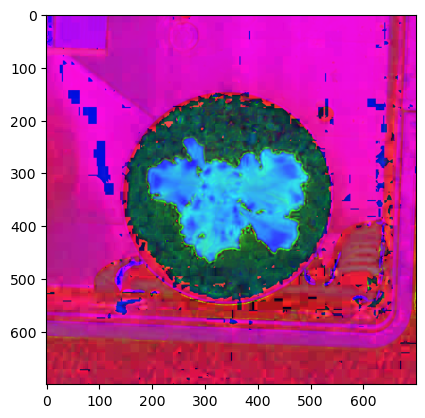

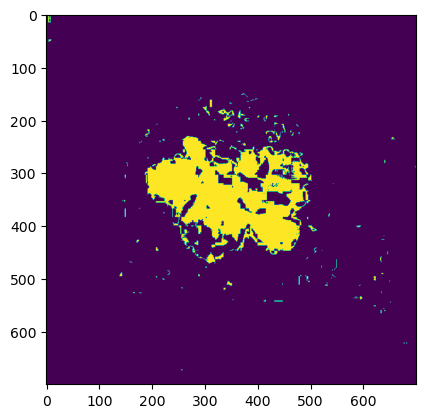

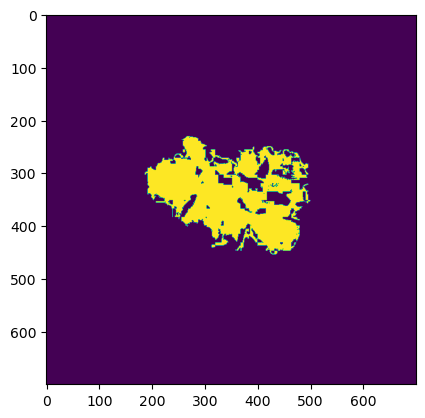

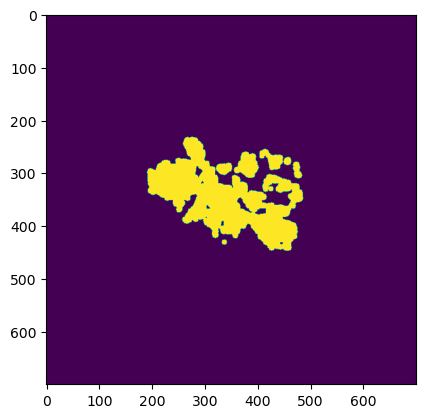

5

In [20]:
medium_example = imread(f"{read_dir}/lettuce4_2024-07-08_15.jpg")
count_leaves(medium_example, True)

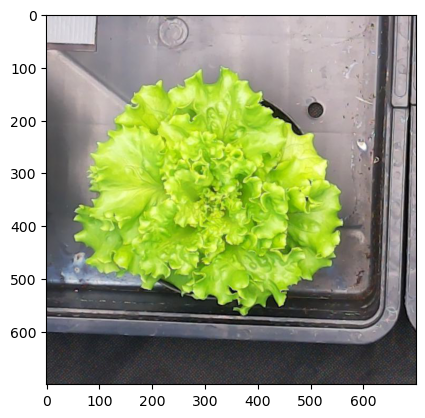

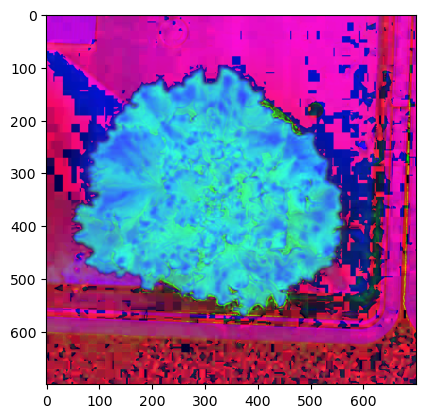

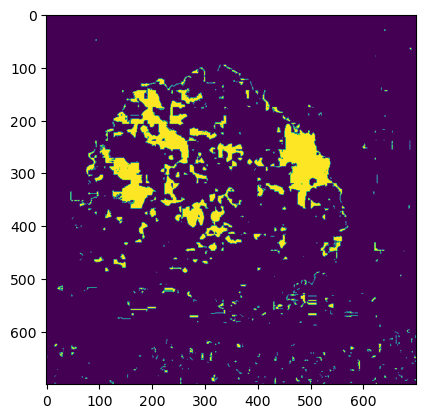

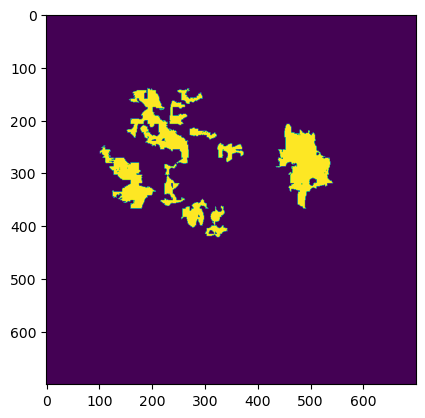

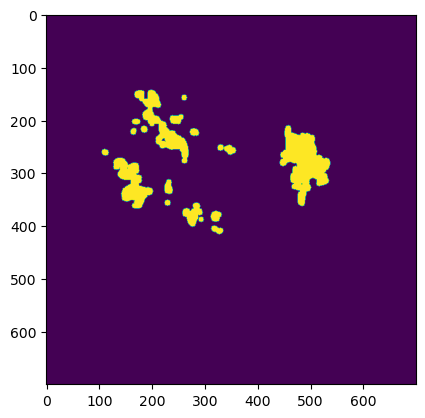

16

In [21]:
big_example = imread(f"{read_dir}/lettuce4_2024-07-18_15.jpg")
count_leaves(big_example, True)

### Counting leaves into Time Series

In [24]:
def process_images(directory):
    # List to store the result rows
    data = []

    # Iterate over all files in the given directory
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith(".jpg"):
            # Extract the plant number and timestamp from the filename
            try:
                parts = filename.replace("lettuce", "").replace(".jpg", "").split("_")
                plant_num = int(parts[0])
                date_time_str = parts[1] + " " + parts[2]
                date_time = datetime.strptime(date_time_str, "%Y-%m-%d %H")
            except (ValueError, IndexError) as e:
                print(f"Error parsing filename: {filename}")
                continue
            
            # Read the image
            image_path = os.path.join(directory, filename)
            image = imread(image_path)
            
            # Count the leaves
            leave_count = count_leaves(image)
            
            # Append the result to the data list
            data.append({
                "plant_num": plant_num,
                "date_time": date_time,
                "leave_count": leave_count
            })
    
    # Create the DataFrame
    df = pd.DataFrame(data, columns=["plant_num", "date_time", "leave_count"])
    
    return df

In [25]:
leave_count_ts = process_images(read_dir)

  0%|          | 0/5505 [00:00<?, ?it/s]

In [26]:
leave_count_ts.sort_values(["plant_num", "date_time"]).to_csv("daylight_leave_count_ts.csv", index=False)

### Analyze the Time Series

In [27]:
df = pd.read_csv("daylight_leave_count_ts.csv")
df["date_time"] = pd.to_datetime(df["date_time"])

In [39]:
# Filter the DataFrame by the time
df = df[(df['date_time'].dt.hour > 7) & (df["date_time"].dt.hour < 20)] \
    .copy().sort_values(["plant_num", "date_time"])

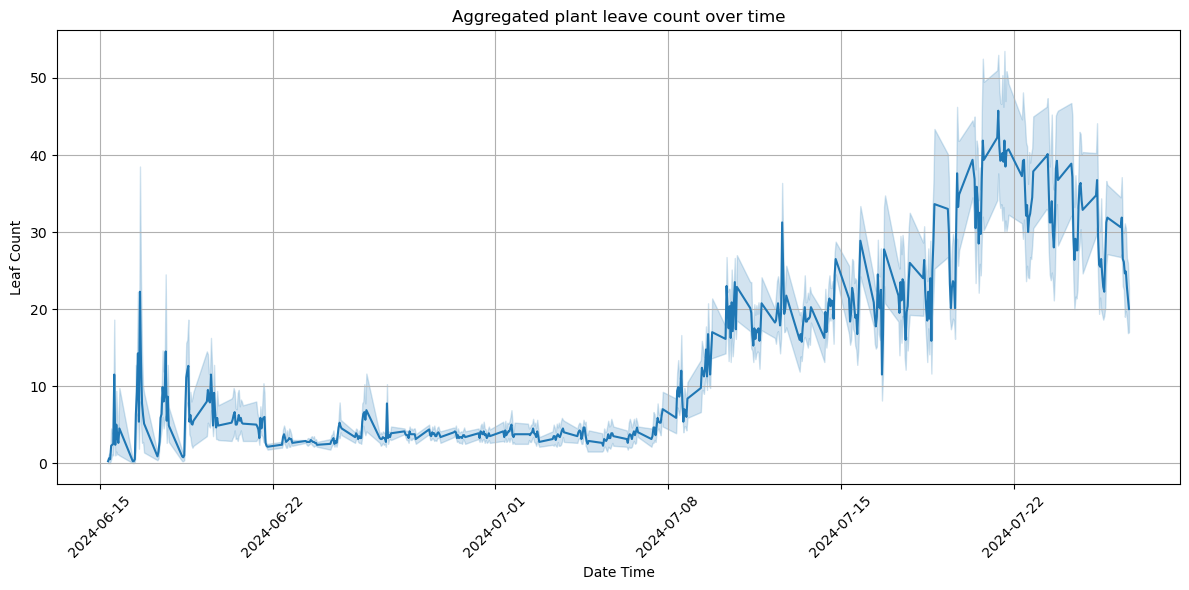

In [45]:
def plot_aggregated(x, y, df):
    fig = plt.figure(figsize=(12, 6))
    
    sns.lineplot(x=x, y=y, data=df)
    plt.xlabel('Date Time')
    plt.ylabel('Leaf Count')
    plt.title('Aggregated plant leave count over time')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()

plot_aggregated(x="date_time", y="leave_count", df=df)

**Number of leaves in TS should be monotonically non-decreasing!**

In [41]:
df_clean = df.groupby('plant_num')[['date_time', "plant_num", 'leave_count']].apply(
    lambda group: group.set_index('date_time')
                .rolling('24h', center=True).median().reset_index()
).reset_index(drop=True)
df_clean["leave_count"] = df_clean \
    .apply(lambda x: 5 if ((x["date_time"] < pd.to_datetime("2024-06-23 12:00:00")) & (x["leave_count"] > 5)) else x["leave_count"], axis=1)

df_clean["plant_num"] = df_clean["plant_num"].astype(int)
df_clean["plant_name"] = df_clean["plant_num"].apply(lambda x: f"plant_{x}")

In [42]:
df_clean

,date_time,plant_num,leave_count,plant_name
0,2024-06-15 08:00:00,1,2.0,plant_1
1,2024-06-15 09:00:00,1,2.0,plant_1
2,2024-06-15 10:00:00,1,2.0,plant_1
3,2024-06-15 11:00:00,1,2.0,plant_1
4,2024-06-15 12:00:00,1,2.0,plant_1
...,...,...,...,...
3995,2024-07-26 12:00:00,8,25.0,plant_8
3996,2024-07-26 13:00:00,8,25.0,plant_8
3997,2024-07-26 14:00:00,8,25.0,plant_8
3998,2024-07-26 15:00:00,8,25.0,plant_8


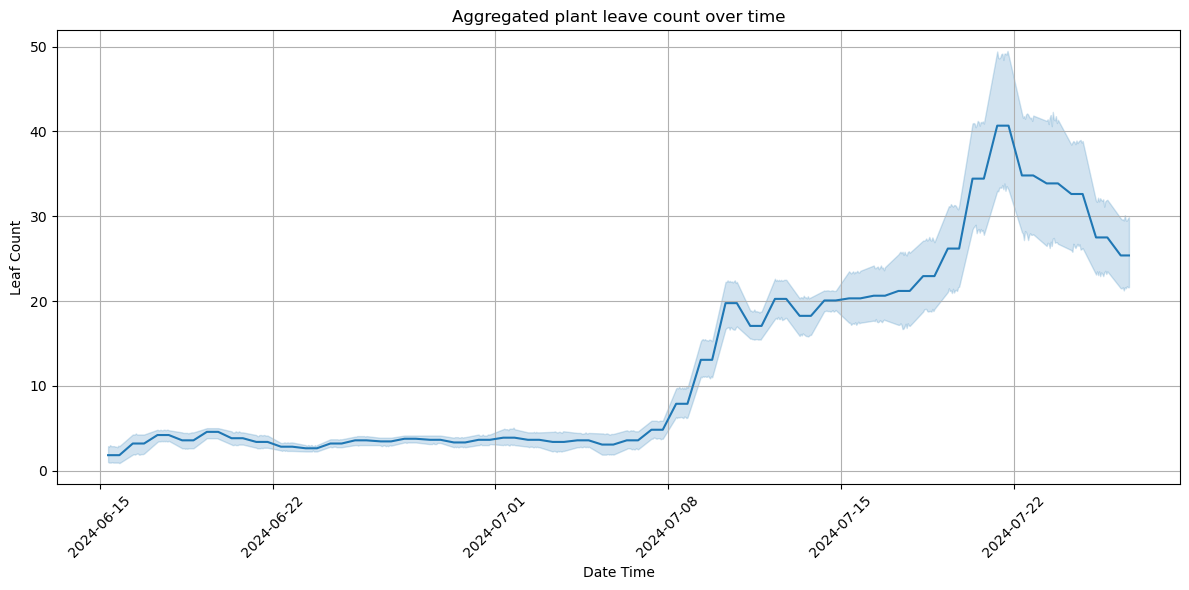

In [46]:
plot_aggregated(x="date_time", y="leave_count", df=df_clean)

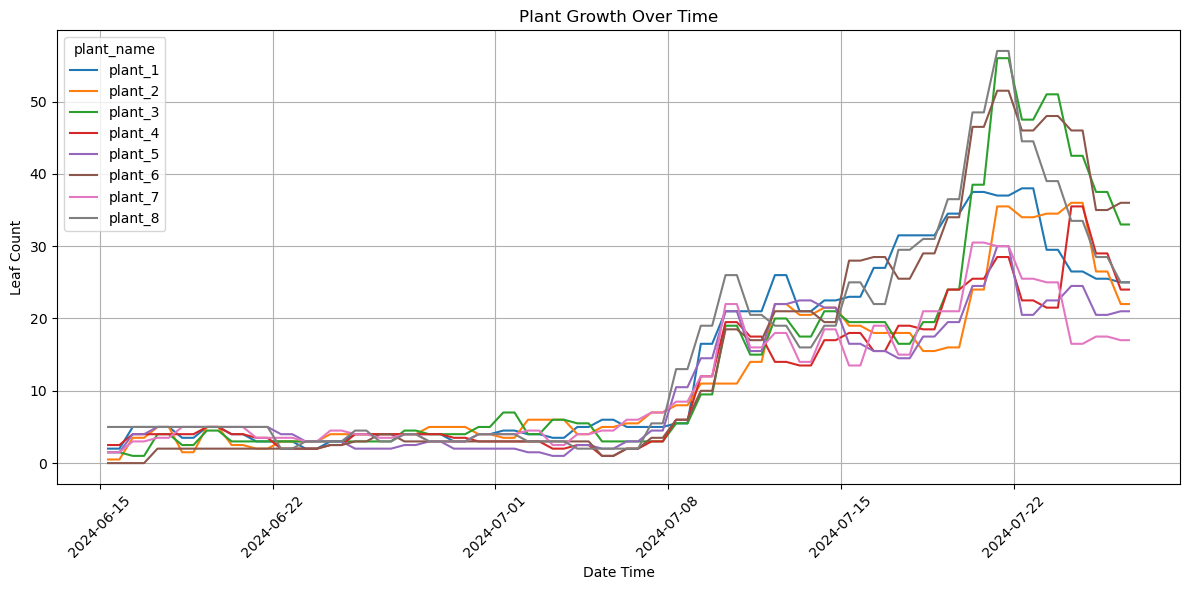

In [43]:
# Set up the plot
plt.figure(figsize=(12, 6))

# Plot data for each plant
sns.lineplot(x="date_time", y="leave_count", hue="plant_name", data=df_clean)

# Add labels and title
plt.xlabel('Date Time')
plt.ylabel('Leaf Count')
plt.title('Plant Growth Over Time')
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

TO DO:
- Play with smoothing of Time Series in order to force non-decreasing